# Домашнее задание №6

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW6 <Фамилия Имя>**

soft deadline: 23.06.2020T23:59:00+0300

hard deadline: 30.06.2020T23:59:00+0300

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить AP@k, где k=10 и посчитать среднее значение этой величины по всем запросам (MAP). Формулу берем из этой презентации: https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-1-per.pdf

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки (annoy, faiss, etc, ..). И помните о том, что время поиска – очень важный параметр.
В случае использования нейросети инференс картинки производите без GPU ускорителя. Для обучения использовать GPU можно. Безусловно **не используйте изобржения из test.dat для обучения сети или построения поисковой базы**. 



---



Для итогового отчета посторойте таблицу в которой будет указано имя метода, значение MAP для этого метода, среднее время работы функции `revtrive` оцененное через утилиту `timeit` внутри GoogleCollab. (Базу вы можете построить на персональном копьютере.)

In [1]:
import pickle
from os import listdir
from os.path import join
from typing import List, Tuple, Dict
from math import ceil
from itertools import product
from time import time

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
np.random.seed(7)

In [3]:
def visualize_grid(data: List[Tuple[np.ndarray, str]], n_rows: int = 1, size: int = 15):
    n_cols = int(ceil(len(data) / n_rows))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size))
    for i, d in enumerate(data):
        ax = axes[i // n_cols][i % n_cols]
        ax.imshow(d[0])
        ax.set_axis_off()
        ax.set_title(d[1])

# Dataset

In [ ]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/Corel-10k.zip
!unzip -q Corel-10k.zip

In [4]:
class ImageDataset:
    def __init__(self, data_dir: str):
        self.__data_dir = data_dir
        self.__images = np.array([self.image_to_id(it) for it in listdir(join(data_dir, "Images"))])
        with open(join(data_dir, "test.dat"), "r") as test_data_file:
            self.__test_images = np.array([self.image_to_id(s.strip()) for s in test_data_file])
        self.__test_images_mask = np.zeros_like(self.__images, dtype=bool)
        self.__test_images_mask[self.__test_images] = True

    @staticmethod
    def image_to_id(image: str) -> int:
        return int(image[:-4])

    @property
    def train_image_ids(self) -> np.ndarray:
        return self.__images[~self.__test_images_mask]
    
    @property
    def test_image_ids(self) -> np.ndarray:
        return self.__images[self.__test_images_mask]

    def __getitem__(self, pos: int) -> Tuple[np.ndarray, int]:
        assert 0 < pos < self.__images.shape[0] + 1
        image = cv2.imread(join(self.__data_dir, "Images", f"{pos}.jpg"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cluster = pos // 100 + 1
        return image, cluster

In [5]:
dataset = ImageDataset("Corel-10k")
dataset.train_image_ids.shape, dataset.test_image_ids.shape

((9000,), (1000,))

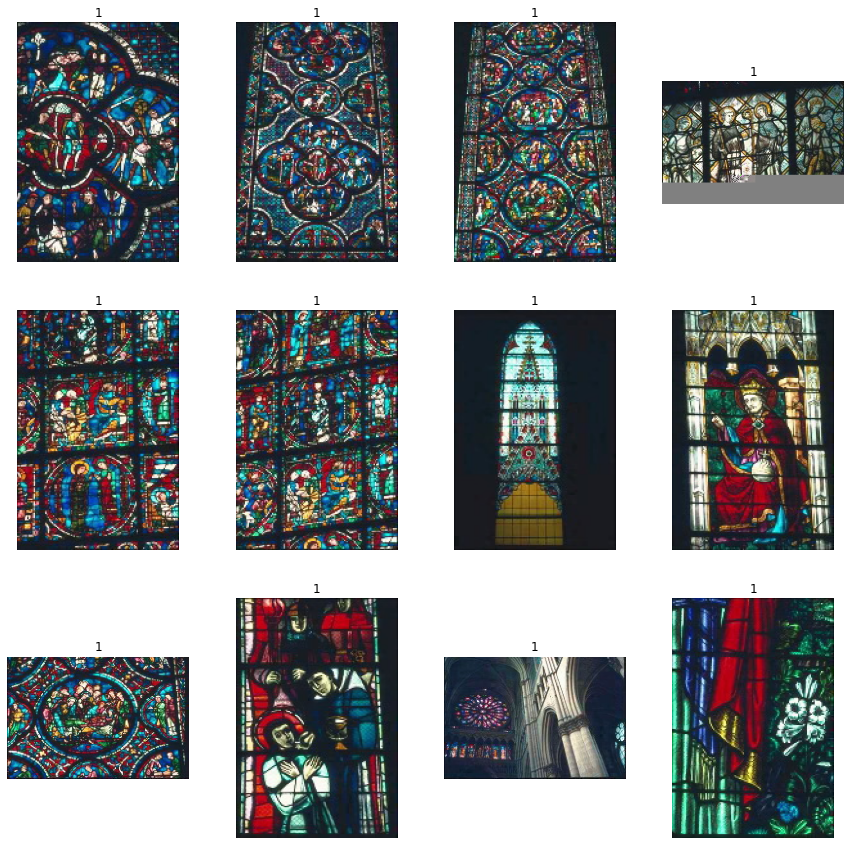

In [6]:
cluster = [dataset[i] for i in range(1, 13)]
visualize_grid(cluster, 3)
plt.show()

# Train
This part can be skipped on inference

In [7]:
train_images, train_clusters = zip(*[dataset[img_id] for img_id in tqdm(dataset.train_image_ids)])

## GIST

In [8]:
class GISTDescriptorBuilder:
    
    def __init__(self, gabour_filter_parameters: List[Dict]):
        self.__kernels = []
        for params in gabour_filter_parameters:
            print(f"Add gabour kernel with parameters:\n{params}")
            self.__kernels.append(cv2.getGaborKernel(**params))
        print(f"Total filters: {len(self.__kernels)}, size of descriptor: {len(self.__kernels) * 16}")

    def __build_gist_descriptor(self, image: np.ndarray) -> np.ndarray:
        h_spl = np.array_split(image, 4, axis=0)
        w_spl = [np.array_split(it, 4, axis=1) for it in h_spl]
        descriptor = np.array([[it.mean() for it in row] for row in w_spl]).reshape(-1)
        return descriptor
        
    def __call__(self, image: np.ndarray) -> np.ndarray:
        r_image = cv2.resize(image, (64, 64))
        cvt_img = cv2.cvtColor(r_image, cv2.COLOR_RGB2HSV)
        filtered_images = [cv2.filter2D(cvt_img, cv2.CV_8UC3, it) for it in self.__kernels]
        return np.concatenate([self.__build_gist_descriptor(it) for it in filtered_images])

In [9]:
ksizes = [(10, 10)]
sigmas = [2., 4., 8.]
thetas = [(np.pi / 2) * i for i in range(4)]
lambdas = [5., 10., 15.]
gammas = [3.]
psis = [0.]

gabour_parameters = []
for ks, s, t, l, g, p in product(ksizes, sigmas, thetas, lambdas, gammas, psis):
    gabour_parameters.append({
        "ksize": ks,
        "sigma": s,
        "theta": t,
        "lambd": l,
        "gamma": g,
        "psi": p
    })

In [10]:
gist_descriptor_builder = GISTDescriptorBuilder(gabour_parameters)

Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 0.0, 'lambd': 5.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 0.0, 'lambd': 10.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 0.0, 'lambd': 15.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 1.5707963267948966, 'lambd': 5.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 1.5707963267948966, 'lambd': 10.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 1.5707963267948966, 'lambd': 15.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta': 3.141592653589793, 'lambd': 5.0, 'gamma': 3.0, 'psi': 0.0}
Add gabour kernel with parameters:
{'ksize': (10, 10), 'sigma': 2.0, 'theta'

In [11]:
ex_descriptor = gist_descriptor_builder(dataset[1][0])
ex_descriptor.shape

(576,)

In [12]:
train_descriptors = np.array([gist_descriptor_builder(it) for it in tqdm(train_images)])

In [13]:
mb_size = train_descriptors.nbytes / 1024 / 1024
f"Memory usage: {mb_size} mb"

'Memory usage: 39.55078125 mb'

## KMeans

In [14]:
N_CLUSTERS = 500

In [15]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=7, verbose=1, max_iter=1000)

In [16]:
kmeans.fit(train_descriptors, train_clusters)

Initialization complete
Iteration 0, inertia 843513301.2476914
Iteration 1, inertia 624317211.0863231
Iteration 2, inertia 607664805.6346848
Iteration 3, inertia 601534471.0565045
Iteration 4, inertia 598787333.1023792
Iteration 5, inertia 597471745.0101485
Iteration 6, inertia 596672324.5269128
Iteration 7, inertia 596219482.7753524
Iteration 8, inertia 595943798.546597
Iteration 9, inertia 595784466.5317163
Iteration 10, inertia 595681787.1131873
Iteration 11, inertia 595647237.5870852
Iteration 12, inertia 595637683.7455668
Converged at iteration 12: center shift 1.7444650249856058e-24 within tolerance 0.04861644906985421
Initialization complete
Iteration 0, inertia 844220007.941803
Iteration 1, inertia 626077137.9762132
Iteration 2, inertia 608640285.9144336
Iteration 3, inertia 602146060.9007215
Iteration 4, inertia 598907677.7391886
Iteration 5, inertia 597077349.1371952
Iteration 6, inertia 595914161.8113146
Iteration 7, inertia 595214516.7980796
Iteration 8, inertia 594854210.8

KMeans(max_iter=1000, n_clusters=500, random_state=7, verbose=1)

In [17]:
cluster_centers = kmeans.cluster_centers_

## LSH

In [18]:
class LSHClusterEncoder:
    __low_bound = -100
    __high_bound = 100

    def __init__(self, cluster_center: np.ndarray, lsh_len: int):
        self.__description_dim = cluster_center.shape[0]
        self.__lsh_len = lsh_len

        self.__coeffs_a = np.random.uniform(
            self.__low_bound, self.__high_bound, (self.__description_dim, self.__lsh_len)
        )
        self.__coeffs_c = -(cluster_center.reshape(1, -1) @ self.__coeffs_a)

    def encode(self, batch_images: np.ndarray) -> np.ndarray:
        return (batch_images @ self.__coeffs_a + self.__coeffs_c) > 0

In [19]:
LSH_LEN = 64

lsh_encoders = [LSHClusterEncoder(it, LSH_LEN) for it in tqdm(cluster_centers)]

In [20]:
encoded_clusters = []
for cluster_id in tqdm(range(N_CLUSTERS)):
    cluster_mask = kmeans.labels_ == cluster_id
    cluster_lsh = lsh_encoders[cluster_id].encode(train_descriptors[cluster_mask])
    cluster_image_ids = dataset.train_image_ids[cluster_mask]
    encoded_clusters.append((cluster_lsh, cluster_image_ids))

## Store

In [21]:
database_path = "database.pkl"

In [22]:
with open(database_path, "wb") as db_file:
    pickle.dump({
        "gist": gist_descriptor_builder,
        "cluster_centers": cluster_centers,
        "lsh_encoders": lsh_encoders,
        "encoded_clusters": encoded_clusters
    }, db_file)

# Retrieve
Start here for inference

In [ ]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/database.pkl

In [23]:
test_images, test_clusters = zip(*[dataset[img_id] for img_id in tqdm(dataset.test_image_ids)])

In [24]:
class ImageRetrieve:
    def __init__(self,
        gist: GISTDescriptorBuilder,
        cluster_centers: np.ndarray,
        lsh_encoders: List[LSHClusterEncoder],
        encoded_clusters: List[Tuple[np.ndarray, np.ndarray]],
        dist_metric: str = "xor"
    ):
        self.__gist_descriptor_builder = gist
        self.__cluster_centers = cluster_centers
        self.__lsh_encoders = lsh_encoders
        self.__encoded_clusters = encoded_clusters
        self.__dist_metric = dist_metric

        n_clusters = kmeans.cluster_centers_.shape[0]
        for i in tqdm(range(n_clusters)):
            encoded_center = lsh_encoders[i].encode(kmeans.cluster_centers_[i].reshape(1, -1))
            assert encoded_center.sum() == 0
        print("Dummy test: passed")

    @staticmethod
    def from_database(database_path: str, dist_metric: str = "xor") -> "ImageRetrieve":
        with open(database_path, "rb") as db_file:
            data = pickle.load(db_file)
        return ImageRetrieve(**data, dist_metric=dist_metric)

    def retrieve(self, image: np.ndarray, topk: int = 1) -> List[np.ndarray]:
        image_descriptor = self.__gist_descriptor_builder(image).reshape(1, -1)
        cluster_ids = np.argsort(
            np.linalg.norm(self.__cluster_centers - image_descriptor, axis=-1)
        )

        result = np.zeros(topk, dtype=np.int32)
        pos = 0
        for cl_id in cluster_ids:
            lsh_encoding = self.__lsh_encoders[cl_id].encode(image_descriptor)
            distances = self.__calculate_dist(self.__encoded_clusters[cl_id][0], lsh_encoding)
            arg_sort = np.argsort(distances)

            needed = topk - pos
            if needed <= arg_sort.shape[0]:
                result[pos:] = self.__encoded_clusters[cl_id][1][arg_sort[:needed]]
                break
            else:
                have = arg_sort.shape[0]
                result[pos: pos + have] = self.__encoded_clusters[cl_id][1][arg_sort]
                pos += have
        return result

    def __calculate_dist(self, lsh_cluster: np.ndarray, lsh_target: np.ndarray) -> np.ndarray:
        if self.__dist_metric == "xor":
            return (lsh_cluster != lsh_target).sum(-1)
        else:
            raise NotImplementedError(f"Unknown distance metric: {self.__dist_metric}")

In [25]:
database_path = "database.pkl"
image_retrieve = ImageRetrieve.from_database(database_path)


Dummy test: passed


In [26]:
N_RANDOM_IMAGES = 5
random_test_images = np.random.choice(dataset.test_image_ids.shape[0], N_RANDOM_IMAGES)

grid_images = []

for image_id in random_test_images:
    closest_images = [dataset[it] for it in image_retrieve.retrieve(test_images[image_id], 3)]

    grid_images.append((test_images[image_id], f"Cluster: {test_clusters[image_id]}"))
    grid_images.extend([(img, f"Cluster: {cls}") for img, cls in closest_images])

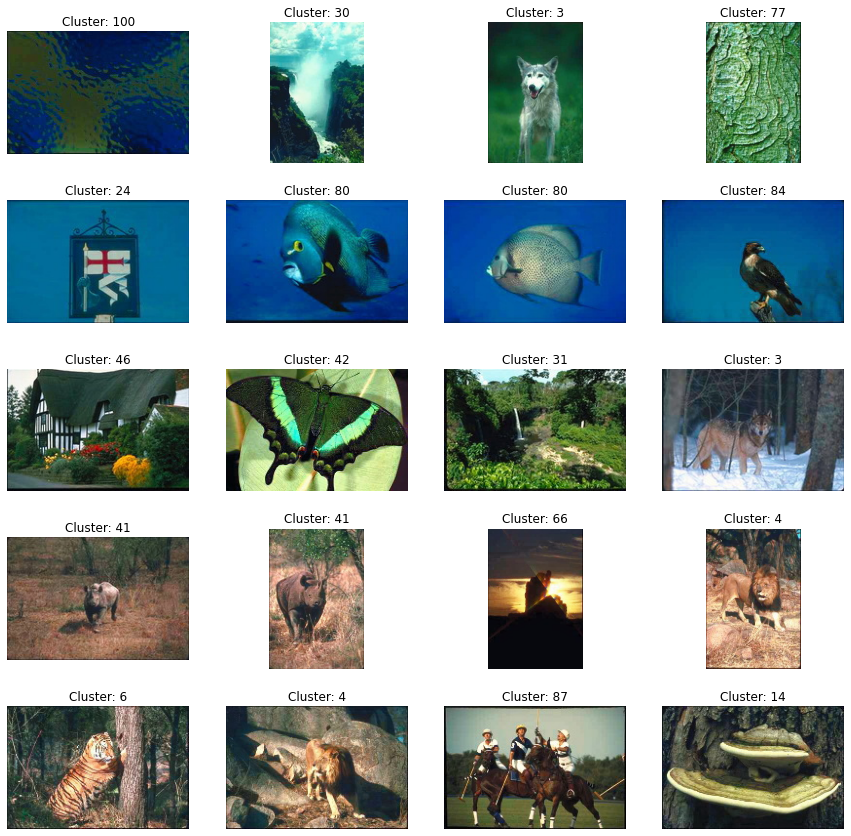

In [27]:
visualize_grid(grid_images, N_RANDOM_IMAGES)
plt.show()

## Time measurement

In [28]:
times = []
for test_image in tqdm(test_images):
    start_time = time()
    image_retrieve.retrieve(test_image)
    finish_time = time()
    times.append(finish_time - start_time)
    
print(f"Average time: {np.mean(times)} ms ± {np.std(times)} ms")


Average time: 0.015572552680969238 ms ± 0.0011474450038868283 ms


## Quality measurement

In [29]:
def mean_average_precision(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculate mean average precision (k == 1..n_preds)
    
    @param y_pred: [batch size; n preds] - predicted clusters
    @param y_true: [batch size; 1] - ground truth clusters
    @return: float - MAP@n_preds
    """
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, 1)
    correct_pred = y_pred == y_true

    # [batch size; n preds]
    true_positives = np.cumsum(correct_pred, axis=-1)
    precision_k = true_positives / np.arange(1, true_positives.shape[1] + 1).reshape(1, -1)

    precision_k[~correct_pred] = 0
    n_correct = correct_pred.sum(-1)
    n_correct[n_correct == 0] = 1  # to avoid zero division (numerator is zero, thus 0/1=0)
    average_precision = precision_k.sum(-1) / n_correct

    return average_precision.mean()

In [30]:
def test1():
    ranking_1 = [1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
    ranking_2 = [0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
    pred = np.array([ranking_1, ranking_2])
    target = np.array([1, 1])
    map_k = mean_average_precision(pred, target)
    true_map_k = (0.78 + 0.52) / 2
    assert round(map_k, 2) == true_map_k, f"{map_k} != {true_map_k}"

def test2():
    ranking_1 = [1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
    ranking_2 = [0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
    pred = np.array([ranking_1, ranking_2])
    target = np.array([1, 1])
    map_k = mean_average_precision(pred, target)
    true_map_k = 0.53
    assert round(map_k, 2) == true_map_k, f"{map_k} != {true_map_k}"
    
test1()
test2()

In [31]:
TOP_K = 10

y_pred = np.zeros((len(test_images), TOP_K))
for i, test_image in tqdm(enumerate(test_images), total=len(test_images)):
    closest_ids = image_retrieve.retrieve(test_image, topk=TOP_K)
    y_pred[i] = [dataset[it][1] for it in closest_ids]

print(f"MAP@10 for test images: {mean_average_precision(y_pred, np.array(test_clusters))}")


MAP@10 for test images: 0.37000635566263546
